## `mosartwmpy` tutorial

This tutorial will demonstrate the basic use of `mosartwmpy` in two scenarios:
* First, in standalone mode where all model inputs are provided from files
* Second, a contrived example of running the model coupled with runoff input from another model

The use of restart files will also be demonstrated.

In [14]:
from datetime import date, datetime
import numpy as np
import os

from mosartwmpy import Model
from mosartwmpy.plotting.plot import plot_reservoir, plot_variable
from mosartwmpy.utilities.download_data import download_data

In [15]:
if 'DATA_DIR' not in os.environ:
    download_data('tutorial')

Download and unpack the tutorial dataset, which covers May of 1981 (this may take a few minutes):

Initialize the model using the provided `config.yaml`, which has the input paths properly specified for this notebook:

In [16]:
mosart_wm = Model()
mosart_wm.initialize('./config.yaml')

Initalizing model...
Done.


The model is now setup to run in standalone mode, with runoff provided from file.

Let's run for a couple weeks in this mode (this may take a couple minutes):

In [17]:
mosart_wm.config["simulation.end_date"] = date(1981, 5, 14)
mosart_wm.update_until(mosart_wm.get_end_time())

Beginning simulation for 1981-05-01 through 1981-05-14...
Running mosartwmpy
Simulation completed in 59.464 seconds.


Let's take a look at how the river channels have formed over this week.

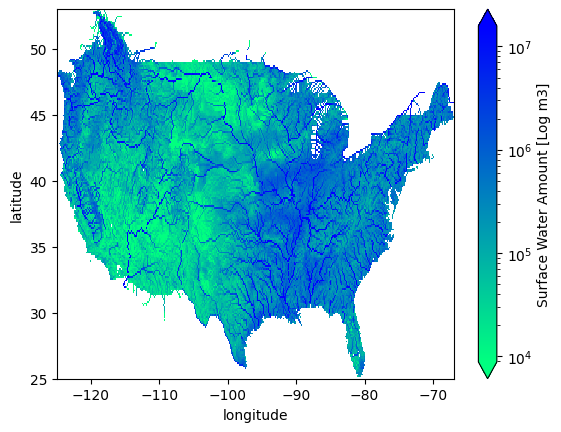

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [18]:
mosart_wm.plot_variable('surface_water_amount', log_scale=True)

We can see the dominant river channels beginning to form! Since the initial conditions have no surface water, it can take a few weeks of model time to get to a good baseline, depending on the amount of rainfall.

Now let's pretend to run the model in coupled mode, as if runoff were being provided by another model such as CLM.

First, we'll implement dummy functions that create random runoff to take the place of the coupled model:

In [19]:
def get_surface_runoff():
    # provide the surface runoff for each grid cell in mm/s
    data = np.random.normal(0.001, 0.001, mosart_wm.get_grid_shape())
    return np.where(
        data < 0,
        0,
        data
    )

def get_subsurface_runoff():
    # provide the subsurface runoff for each grid cell in mm/s
    data = np.random.normal(0.00015, 0.00015, mosart_wm.get_grid_shape())
    return np.where(
        data < 0,
        0,
        data
    )

In coupled mode, we'll need to run the model in chunks of time that correspond to the coupling period and update the coupled variables between chunks. For this example, let's say the coupling period is one day -- so we'll update the runoff variables after each day of model time. The same technique could be extended to run the coupled model between each day rather than generating synthetic data.

In [20]:
# first, disable reading runoff from file
mosart_wm.config["runoff.read_from_file"] = False

# set the end date for two weeks out
mosart_wm.config["simulation.end_date"] = date(1981, 5, 28)

# for each day, set the runoff and simulate for one day
# note that the model expects the input flattened as a 1-d array
while mosart_wm.get_current_time() < mosart_wm.get_end_time():
    # set the surface runoff from a coupled model
    mosart_wm.set_value('surface_runoff_flux', get_surface_runoff().flatten())
    # set the subsurface runoff from a coupled model
    mosart_wm.set_value('subsurface_runoff_flux', get_subsurface_runoff().flatten())
    # simulate for one day
    day = date.fromtimestamp(mosart_wm.get_current_time())
    while day == date.fromtimestamp(mosart_wm.get_current_time()):
        mosart_wm.update()
    


Let's see how the random rainfall affected the river channels...

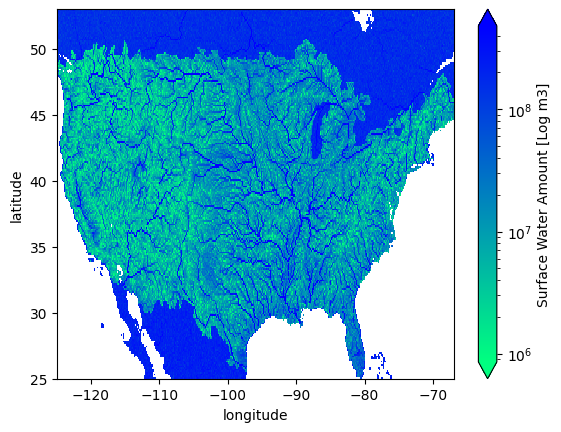

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [21]:
mosart_wm.plot_variable('surface_water_amount', log_scale=True)

Oops, looks like we flooded Canada and Mexico. The river network isn't very well defined there (the tutorial only includes CONUS data for the most part) so it makes sense. Depending on the random data generation, you're probably seeing a lot more water across the CONUS too.

And how about the reservoir storage?

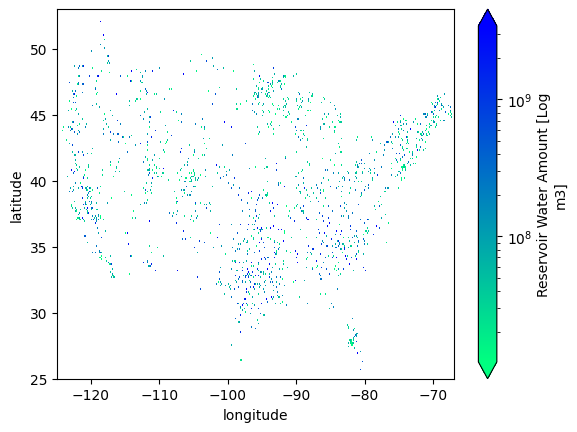

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [22]:
mosart_wm.plot_variable('reservoir_water_amount', log_scale=True)

Let's try restarting the simulation after the original two weeks in May, and run the second two weeks with the runoff from the file. By default, restart files are produced at the end of each model year and also at the end of each simulation. The provided `config_with_restart.yaml` file will use the restart file from 1981-05-15. You can also use a restart file like an initial conditions file by setting the start date to whatever date you choose. But in this case we'll restart where we left off.

In [23]:
mosart_wm = Model()
mosart_wm.initialize('./config_with_restart.yaml')
mosart_wm.config["simulation.start_date"] = date(1981, 5, 15)
mosart_wm.config["simulation.end_date"] = date(1981, 5, 28)
mosart_wm.update_until(mosart_wm.get_end_time())

Initalizing model...
Loading restart file from: `./output/tutorial/restart_files/tutorial_restart_1981_05_15.nc`.
Done.
Beginning simulation for 1981-05-15 through 1981-05-28...
Running mosartwmpy
Simulation completed in 59.968 seconds.


Let's look at the surface water and reservoir storage again:

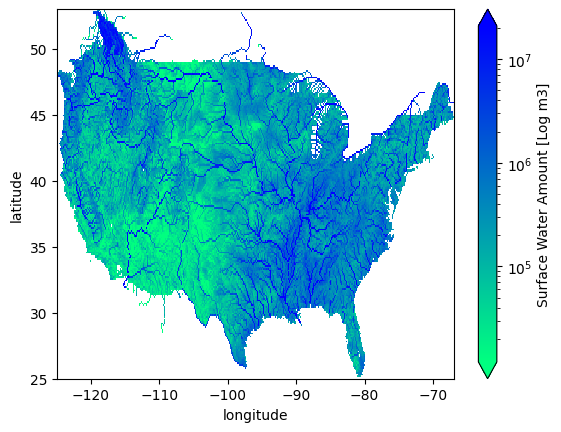

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [25]:
mosart_wm.plot_variable('surface_water_amount', log_scale=True)

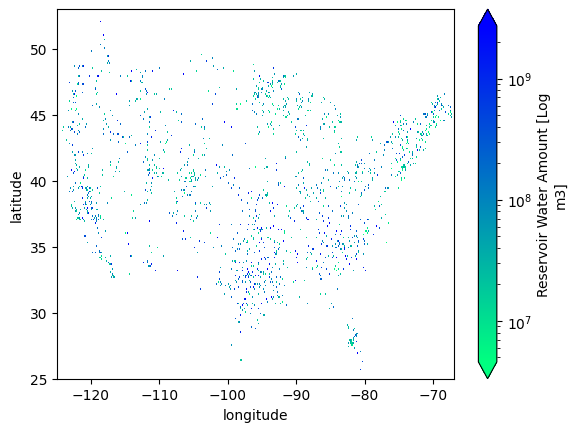

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [26]:
mosart_wm.plot_variable('reservoir_water_amount', log_scale=True)

These plots make more sense than the random runoff!

`mosartwmpy` also includes visualization methods to examine the output over time. For instance, one can plot the behavior of a specific reservoir or create a timeplayer of the water deficit:

/opt/conda/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)
/opt/conda/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


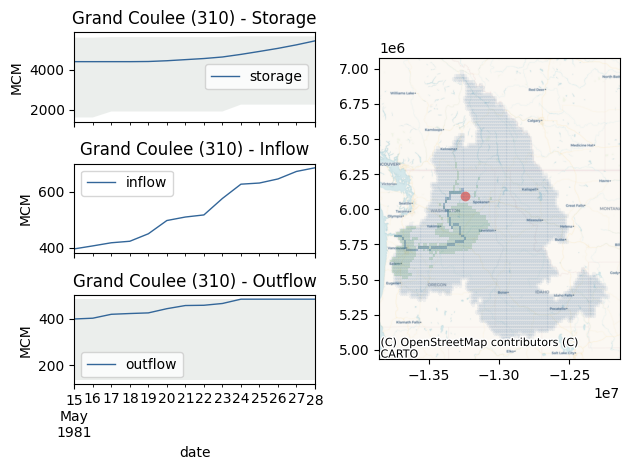

In [27]:
plot_reservoir(
    model=mosart_wm,
    grand_id=310,
    start='1981-05-01',
    end='1981-05-31',
)

This concludes the `mosartwmpy` tutorial. Feel free to open issues with your feedback or start topics on the discussion board!